<a href="https://colab.research.google.com/github/KidMarten/CNN-Emotions-Classifier/blob/master/EmotionRecognition_TF2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import os
import pip
import time

!pip install -q tensorflow-gpu==2.0.0-rc0
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img


import sklearn
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import tensorflow_datasets as tfds



print(tf.__version__)

Using TensorFlow backend.


2.0.0-rc0


#### Data import

In [0]:
train_ds = tfds.load(name="celeb_a", split=tfds.Split.TRAIN)

In [0]:
test_ds = tfds.load(name="celeb_a", split=tfds.Split.TEST)

In [0]:
IMG_SIZE = (218, 178, 3)
BATCH_SIZE = 64

In [0]:
#train = train_ds.repeat().shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test = test_ds.repeat().shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
test = test_ds.batch(BATCH_SIZE)

#### Sequence Generator

In [0]:
class CelebsSequence(keras.utils.Sequence):
    def __init__(self, df_path, data_path, im_size, batch_size, mode='train', categorical=False):
        """
        df_path: path to a .csv file that contains columns with image names and labels
        data_path: path that contains the training images
        im_size: image size
        mode: when in training mode, data will be shuffled between epochs
        """
        self.df = pd.read_csv(df_path).iloc[:35000,:]
        self.im_size = im_size
        self.batch_size = batch_size
        self.mode = mode
        self.categorical = categorical
         # Take labels and a list of image locations in memory
        self.labels = list(self.df['Male'])
        self.image_list = list(data_path+self.df['image_id'])
    
    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        # Shuffles indexes after each epoch
        self.indexes = range(len(self.image_list))
        
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))
            
        elif self.mode == 'val':
            self.indexes = range(100)

    def get_batch_labels(self, idx): 
        
        if self.categorical:
          return np_utils.to_categorical(self.labels[idx * self.batch_size: (idx + 1) * self.batch_size])
        
        else:
          return self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]

    def get_batch_features(self, idx):
        
        batch_images = self.image_list[idx * self.batch_size: (1 + idx) * self.batch_size]
        return np.array([load_image(im, self.im_size) for im in batch_images])

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

#### Model

In [0]:
def model():
  inputs = layers.Input(shape=IMG_SIZE)
  conv1 = layers.Conv2D(filters=64, kernel_size=(5,5), strides=2, activation='relu')(inputs)
  conv1 = layers.BatchNormalization()(conv1)
  conv1 = layers.MaxPooling2D(pool_size=(2,2), strides=1)(conv1)
  conv1 = layers.Dropout(rate=0.3)(conv1)
  
  conv2 = layers.Conv2D(filters=128, kernel_size=(5,5), strides=2, activation='relu')(conv1)
  conv2 = layers.BatchNormalization()(conv2)
  conv2 = layers.MaxPooling2D(pool_size=(2,2), strides=1)(conv2)
  conv2 = layers.Dropout(rate=0.25)(conv2)
  
  conv3 = layers.Conv2D(filters=256, kernel_size=(5,5), strides=2, activation='relu')(conv2)
  conv3 = layers.BatchNormalization()(conv3)
  conv3 = layers.MaxPooling2D(pool_size=(2,2), strides=1)(conv3)
  conv3 = layers.Dropout(rate=0.25)(conv3)

  flatten = layers.Flatten()(conv1)
  dense1 = layers.Dense(512, activation='relu')(flatten)
  dropout = layers.Dropout(rate=0.3)(dense1)
  dense2 = layers.Dense(258, activation='relu')(dropout)
  output = layers.Dense(1, activation='sigmoid', name='output')(dense2)
   
  Model = models.Model(inputs=inputs, outputs=output)
  return Model

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

In [0]:
model = model()

In [0]:
def train(model, dataset, optimizer):
  count = 0
  for example in dataset:
    
    with tf.GradientTape() as tape:
      
      x = example['image'].numpy().astype(np.float32)
      y = example['attributes']['Smiling'].numpy().astype(np.float32)
      
      prediction = model(x)
      loss = tf.keras.losses.binary_crossentropy(prediction, y)
      
      if count % 10 == 0:
        print(tf.keras.backend.mean(loss), end='\r')
      
      count+=1
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [0]:
train(model, test, optimizer)

True
[[1.]]


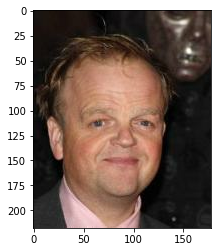

False
[[1.]]


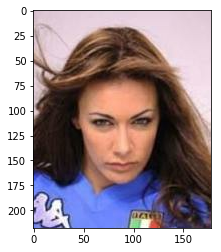

In [15]:
for example in test_ds.take(1):
  print(example['attributes']['Smiling'].numpy())
  print(model.predict(np.expand_dims(example['image'], 0).astype(np.float32)))
  plt.imshow(example['image'])
  plt.show()

#### Results

In [0]:
class ClassifierResults:
  def __init__(self, model, x_test, y_test, metrics=[]):
    self.model = model
    self.x_test = x_test
    self.y_test = y_test
    self.metrics = metrics
    self.predictions = self.model.predict(self.x_test)
    
  def display_preds(self, img_array, labels):
    for i in range(img_array.shape[0]):
        print(labels[i])
        plt.imshow(img_array[i])
        plt.show()
  
  def correct_predictions(self, display=False):
    y_test_classes = np.argmax(self.y_test, axis=1)
    y_pred_classes = np.argmax(self.predictions, axis=1)
    mask = (y_test_classes - y_pred_classes == 0)
    correct_preds = self.x_test[mask]
    correct_labels = self.predictions[mask]
    if display:
      self.display_preds(correct_preds, correct_labels)
    return correct_preds
    
  def wrong_predictions(self, display=True):
    y_test_classes = np.argmax(self.y_test, axis=1)
    y_pred_classes = np.argmax(self.predictions, axis=1)
    mask = (y_test_classes - y_pred_classes != 0)
    wrong_preds = self.x_test[mask]
    wrong_labels = self.predictions[mask]
    print('Number of misclassified pictures: ', wrong_preds.shape[0])
    if display:
      self.display_preds(wrong_preds, wrong_labels)
    return wrong_preds
    
  def scores(self):
    for metric in self.metrics:
      score = metric(np.argmax(self.y_test, axis=1), np.argmax(self.predictions, axis=1))
      print(f'{str(metric)}: ', score)
  
  def confusion_matrix(self, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    matrix = confusion_matrix(np.argmax(self.y_test, axis=1), np.argmax(self.predictions, axis=1))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(self.predictions.shape[1])
    plt.xticks(tick_marks, range(self.predictions.shape[1]), rotation=45)
    plt.yticks(tick_marks, range(self.predictions.shape[1]))
    if normalize:
        matrix = np.round(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], 2)
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')